# Colorifying Black&While images with GAN

In [0]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   1501      0 --:--:-- --:--:-- --:--:--  1497
    100% |████████████████████████████████| 5.7MB 6.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62a14000 @  0x7f213a1a62a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Cloning into 'course-v3'...
remote: Enumerating objects: 2685, done.
remote: Total 2685 (delta 0), re

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
path = Path('/gdrive/My Drive/data/colorify')

In [0]:
path.ls()

[PosixPath('/gdrive/My Drive/data/colorify/models'),
 PosixPath('/gdrive/My Drive/data/colorify/blackwhite'),
 PosixPath('/gdrive/My Drive/data/colorify/images.csv'),
 PosixPath('/gdrive/My Drive/data/colorify/originals'),
 PosixPath('/gdrive/My Drive/data/colorify/image_gen'),
 PosixPath('/gdrive/My Drive/data/colorify/test')]

## Data

### Download
Get high quality data from EyeEm

In [0]:
import re
import requests
from tqdm import tqdm

In [0]:
# pattern to find the width in a url
width_pattern = r'w\/[0-9]+\n'

index = 0
folder = path/'originals'
urls = open((path/'images.csv').as_posix())
for url in tqdm(urls):
    url = url.rstrip('\n\r')
    # clean the url to get a specific width
    url = re.sub(width_pattern, 'w/1000', url)
    # skip empty urls:
    if url == '':
        continue
    # send an HTTP request to get the image
    response = requests.get(url, stream=False)
    # get the image filename
    index += 1
    fname = '{0:05d}'.format(index) + '.jpg'
    # write the response content into a file
    with open((folder/fname).as_posix(), mode='wb') as localfile:
        localfile.write(response.content)

### Black & White
Turn every image in the dataset into a Balck & White image

In [0]:
path_hr = path/'originals'
path_lr = path/'blackwhite'

In [0]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    # turn into gray scale
    bw = img.convert('L')
    img = bw.convert('RGB')
    # save the resulting crappy image
    q = random.randint(50,70)
    img.save(dest, quality=q)

In [0]:
il = ImageItemList.from_folder(path_hr)
parallel(crappify, il.items)

In [0]:
#bs,size=32, 128
# bs,size = 24,160
bs,size = 8,256
arch = models.resnet34

## Pre-train generator

In [0]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

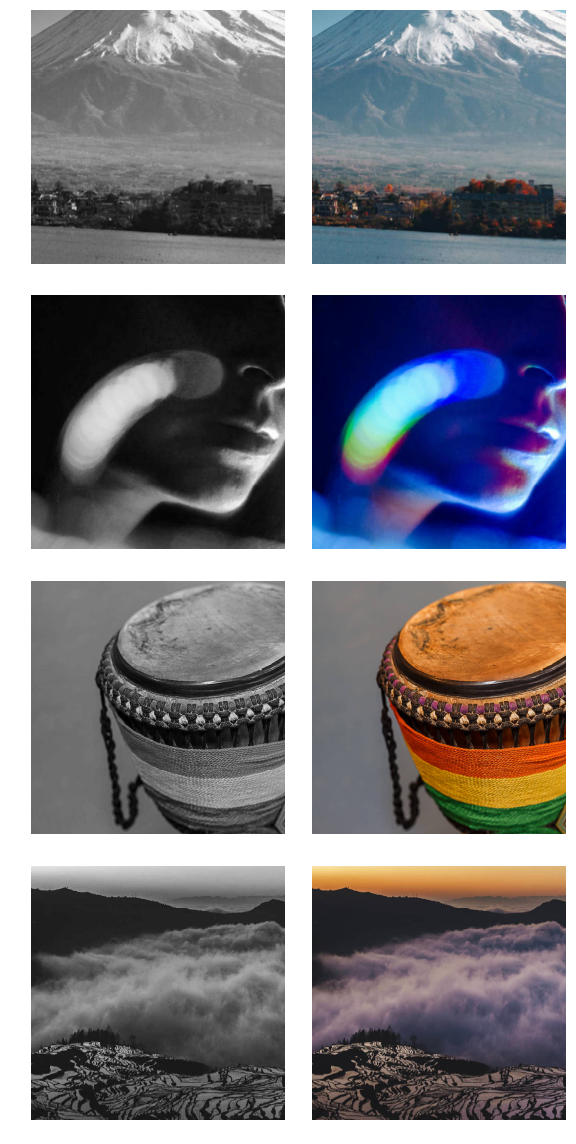

In [0]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

In [0]:
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [0]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 26956673.28it/s]


In [0]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [0]:
learn_gen.unfreeze()

In [0]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

let's see the first results from training the generator

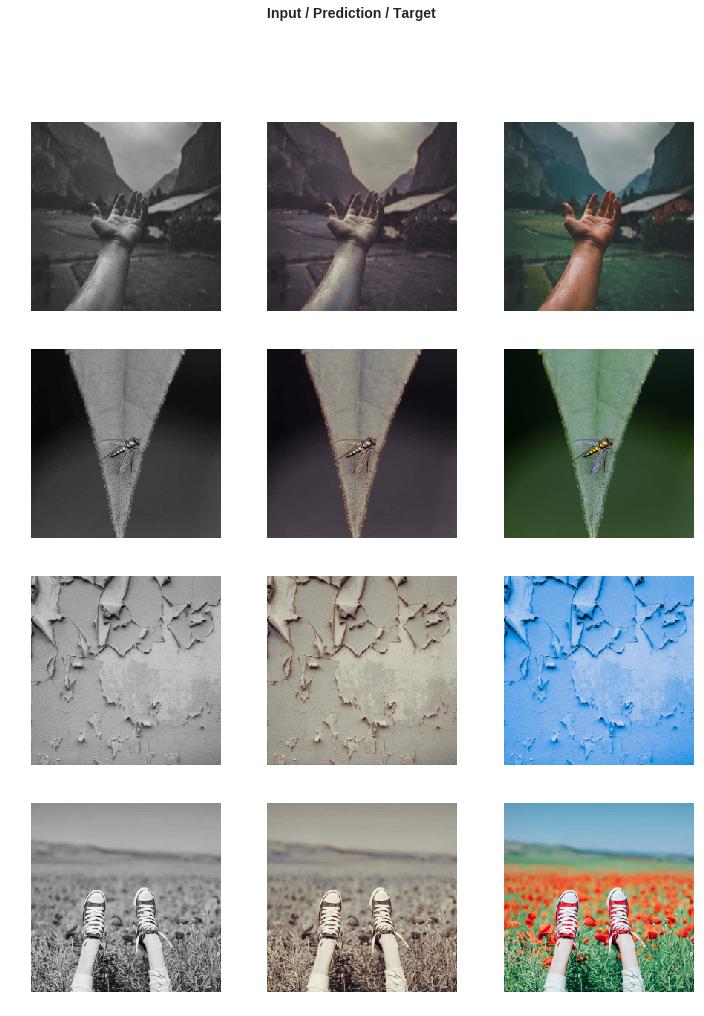

In [0]:
learn_gen.show_results(rows=4)

In [0]:
learn_gen.save('gen-pre2')

### Save generated images

In [0]:
learn_gen.load('gen-pre2');

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

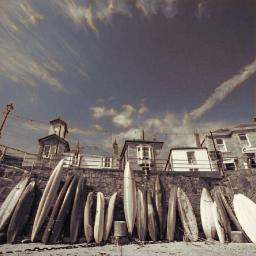

In [0]:
PIL.Image.open(path_gen.ls()[0])

## Train Descriminator

Reclaim GPU memorry back

In [0]:
learn_gen=None
gc.collect()

3623

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageItemList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

Pretrain the descrimator on crappy back 7 white vs not crappy colorized ones.

In [0]:
data_crit = get_crit_data([name_gen, 'originals'], bs=bs, size=size)

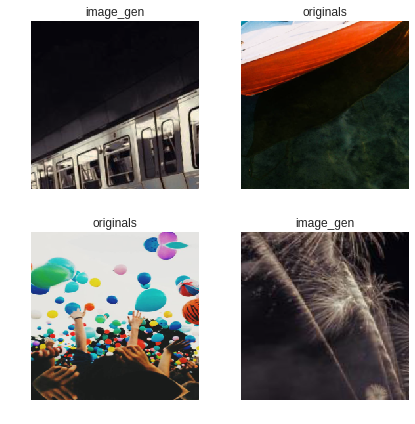

In [0]:
data_crit.show_batch(rows=2, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [0]:
learn_critic.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


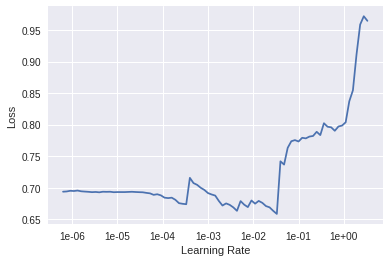

In [0]:
learn_critic.recorder.plot()

In [0]:
learn_critic.fit_one_cycle(6, 5e-4)

In [0]:
learn_critic.save('critic-pre2')

## GAN
Let's comabine the Generator and Descriminator models into one that will generate colorized picturecs and evaluate them. Doing these in a ping-pong fashion to keep gettting the generator better at generate colorized pictures to the point it get's harder for the evaluation task by the descrimitor.

In [0]:
learn_crit=None
learn_gen=None
gc.collect()

24076

In [0]:
data_crit = get_crit_data(['blackwhite', 'originals'], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')

### ping-pong

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

In [55]:
learn.fit(50,lr)

In [0]:
learn.save('gan-1c')

In [0]:
learn.data=get_data(16,192)

In [58]:
learn.fit(10,lr/2)

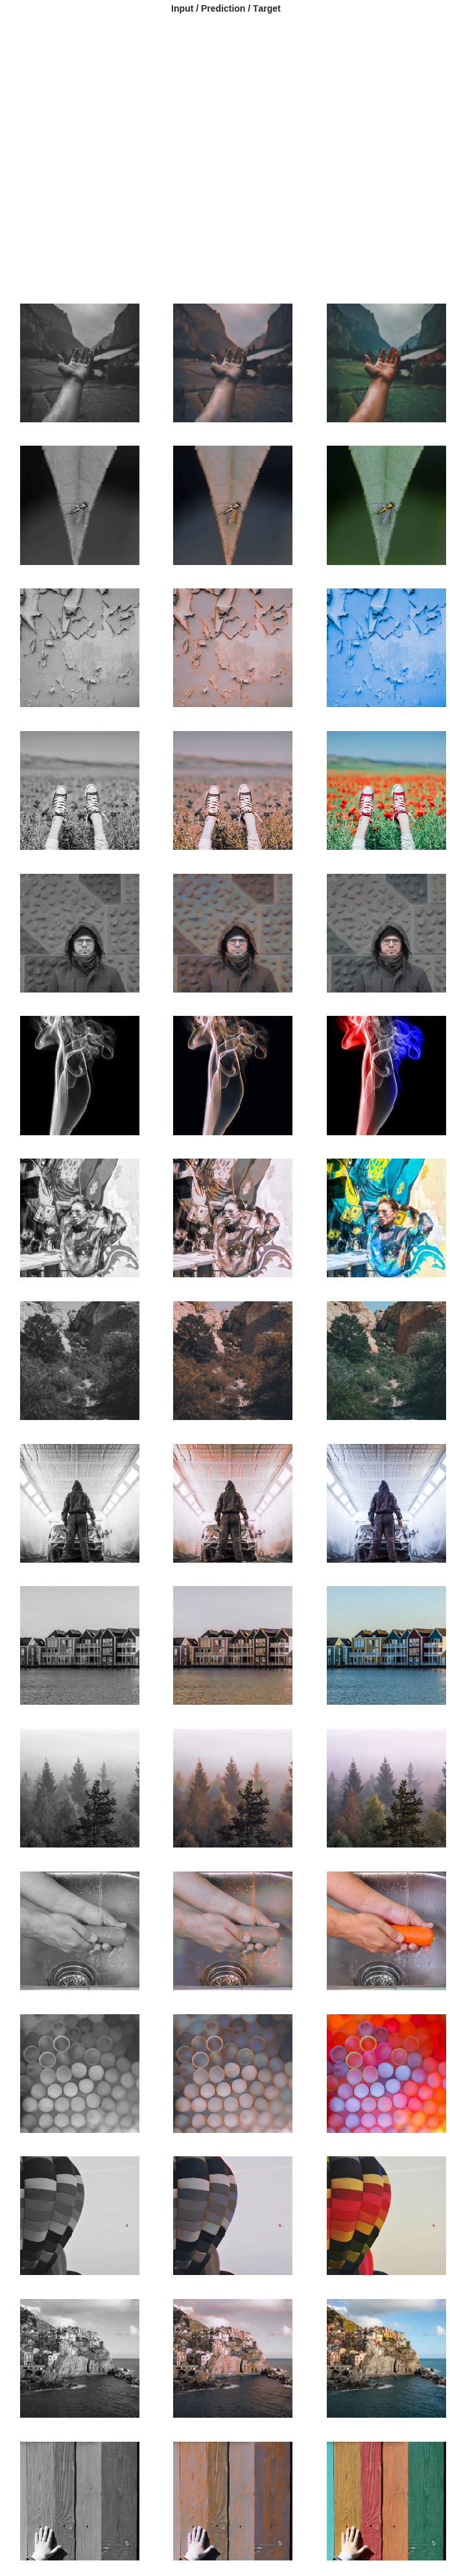

In [59]:
learn.show_results(rows=16)

In [60]:
learn.fit(1,lr)

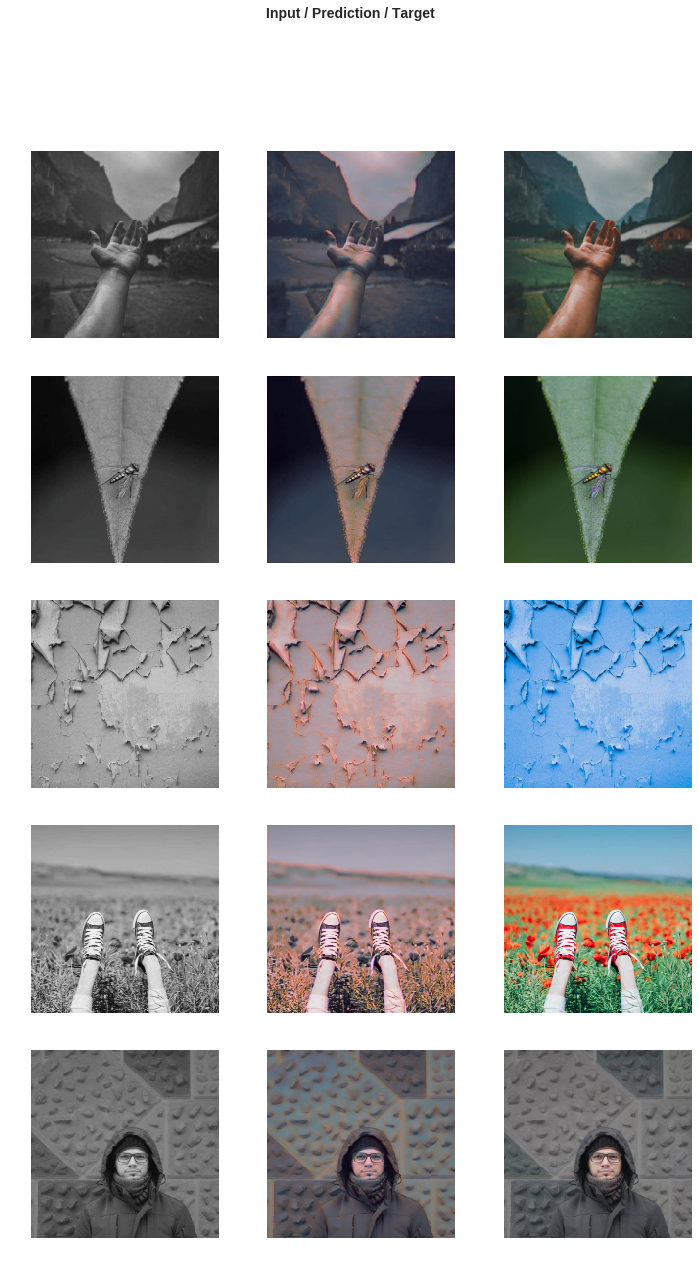

In [61]:
learn.show_results(rows=5)

In [0]:
learn.save('gan-1c')

## Test

In [63]:
learn.load('gan-1c')

GANLearner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (1310 items)
[Image (3, 700, 1050), Image (3, 698, 1050), Image (3, 704, 1250), Image (3, 600, 800), Image (3, 626, 700)]...
Path: /gdrive/My Drive/data/colorify/blackwhite
x: ImageImageList (1310 items)
[Image (3, 700, 1050), Image (3, 698, 1050), Image (3, 704, 1250), Image (3, 600, 800), Image (3, 626, 700)]...
Path: /gdrive/My Drive/data/colorify/blackwhite;

Valid: LabelList
y: ImageItemList (145 items)
[Image (3, 675, 450), Image (3, 633, 950), Image (3, 638, 850), Image (3, 766, 1150), Image (3, 700, 1050)]...
Path: /gdrive/My Drive/data/colorify/blackwhite
x: ImageImageList (145 items)
[Image (3, 675, 450), Image (3, 633, 950), Image (3, 638, 850), Image (3, 766, 1150), Image (3, 700, 1050)]...
Path: /gdrive/My Drive/data/colorify/blackwhite;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), pad

In [64]:
path_test = path/'test'; path_test.ls()

[PosixPath('/gdrive/My Drive/data/colorify/test/three-sunflowers-still-life-in-black-and-white-garry-gay.jpg'),
 PosixPath('/gdrive/My Drive/data/colorify/test/empty-abandoned-house-bw-mikulla.jpg'),
 PosixPath('/gdrive/My Drive/data/colorify/test/aqtp9glidivnzmwpwlno.jpg'),
 PosixPath('/gdrive/My Drive/data/colorify/test/2013-08-29-MitchDobrowner_TreesClouds.jpg')]

In [0]:
fn = path_test.ls()[1]

In [66]:
img = open_image(fn); img.shape

torch.Size([3, 2400, 2400])

In [0]:
_,img_hr,b = learn.predict(img)

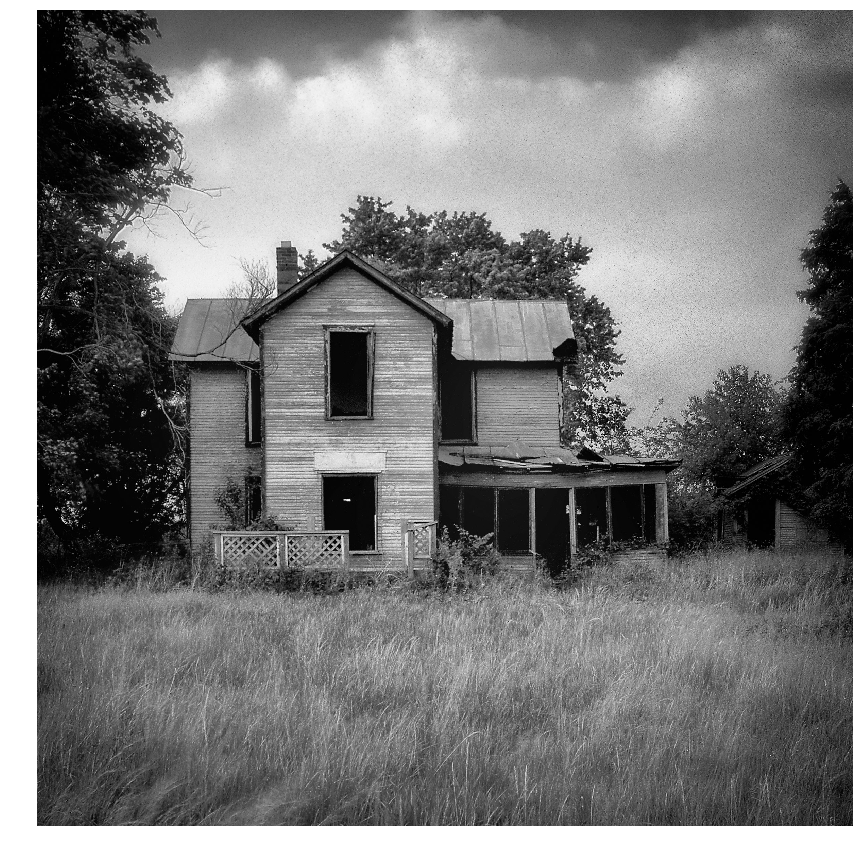

In [68]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [69]:
Image(img_hr).show(figsize=(18,15))

ValueError: ignored

In [0]:
!cp models/* /gdrive/My\ Drive/data/colorify/models/

In [73]:
!curl -o test_image.jpg https://cdn5.eyeem.com/thumb/983f6d7762399d0347750ff3f237819284a9e424-1533988945869/w/1000

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44113    0 44113    0     0   198k      0 --:--:-- --:--:-- --:--:--  198k


In [0]:
fn = 'test_image.jpg'

In [75]:
img = open_image(fn); img.shape

torch.Size([3, 564, 1000])

In [0]:
_,img_hr,b = learn.predict(img)

ValueError: ignored

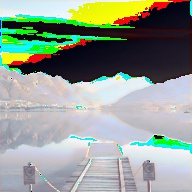

In [77]:
Image(img_hr+0.4282)

In [0]:
_,img_hr,b = learn.predict(img)

In [79]:
img_hr

tensor([[[0.4234, 0.4175, 0.4103,  ..., 0.5744, 0.6136, 0.6126],
         [0.4027, 0.3990, 0.3870,  ..., 0.5854, 0.6485, 0.6774],
         [0.3931, 0.3853, 0.3715,  ..., 0.5948, 0.6570, 0.6776],
         ...,
         [0.2307, 0.2021, 0.1912,  ..., 0.3341, 0.3340, 0.3216],
         [0.2067, 0.1840, 0.1691,  ..., 0.2706, 0.2854, 0.3052],
         [0.2483, 0.1971, 0.2178,  ..., 0.2717, 0.2868, 0.3163]],

        [[0.4561, 0.4485, 0.4463,  ..., 0.5937, 0.5766, 0.5419],
         [0.4678, 0.4629, 0.4619,  ..., 0.5852, 0.5650, 0.5577],
         [0.4730, 0.4691, 0.4678,  ..., 0.5969, 0.5537, 0.5528],
         ...,
         [0.1953, 0.1836, 0.2045,  ..., 0.3168, 0.3213, 0.3198],
         [0.1637, 0.1307, 0.1514,  ..., 0.2896, 0.2976, 0.3002],
         [0.1984, 0.1818, 0.1934,  ..., 0.2824, 0.2980, 0.3113]],

        [[0.4726, 0.4820, 0.4877,  ..., 0.6187, 0.5755, 0.5549],
         [0.4811, 0.5017, 0.5162,  ..., 0.6276, 0.5791, 0.5548],
         [0.4892, 0.5176, 0.5360,  ..., 0.6559, 0.5574, 0.